In [1]:
# VAE w/o correlation regularization for BC
# archetype
# Ec as W

# redo simulation test of archetypes at gene level
# add correlation estimate (test if PBMC capture high and one-to-one mapping of corrleation)
# add pseudospots more real (STsimulate, or STdeconvolve simulation data instead of simple archetypes to achieve diganal pattern, to increase power of pseudospots)

In [5]:
# load modules
import os
import sys
import gzip
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle
import anndata
import scanpy as sc
import scipy
import seaborn as sns

from ST_simulation import *

In [2]:
import phenograph # install from https://github.com/jacoblevine/PhenoGraph
import collections
from scipy.io import mmread,mminfo
from sklearn.decomposition import PCA

# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
meta_df = pd.read_csv('/Users/xueerchen/Downloads/ST_simulation-master/pbmc/Smart-Seq2_meta.csv',index_col=0)#pd.read_csv('/Users/xueerchen/Downloads/ST_simulation-master/pbmc/quartz_meta.csv',index_col=0)
#print(meta_df.head())
exp_df = pd.read_csv('~/Downloads/ST_simulation-master/pbmc/Smart-Seq2_exp.csv',index_col=0)
#print(exp_df.head())
uni_labels = meta_df['nnet2'].unique()
labels = meta_df
cnt = exp_df

### Define uniform VS sparse cell types (w more sparse = 0)
uniform_ct = np.random.choice([0, 1], size=len(uni_labels), p=[0.1, 0.9])

#### Define low VS high density cell types (w more low density = 1)
uni_low = np.random.choice([0, 1], size=len(uni_labels[uniform_ct == 1]),  p=[0.9, 0.1])
reg_low = np.random.choice([0, 1], size=len(uni_labels[uniform_ct == 0]),  p=[0.9, 0.1])

design_df = pd.DataFrame({'uniform': uniform_ct}, index=uni_labels)

design_df['density'] = np.nan
design_df.loc[design_df.index[design_df.uniform == 1], 'density'] = uni_low
design_df.loc[design_df.index[design_df.uniform == 0], 'density'] = reg_low

design_df

,uniform,density
NK_cell,1,0
B_cell,1,0
CD4+_T-cell,1,0
HEK293T_cell,1,0
CD8+_T-cell,1,0
CD14+_Monocyte,1,0
FCGR3A+_Monocyte,1,0
Dendritic_cell,1,0


In [6]:
tot_spots = 6000
percent_uniform = 90#80
percent_sparse = 10
mean_low = 0.8
mean_high = 3#2.5
### Generate no of spots per cell type 
# Uniform ~ 60% of spots, sparse ~ 5% of spots
mean_unif = round((tot_spots / 100) * percent_uniform)
mean_sparse = round((tot_spots / 100) * percent_sparse)
sigma_unif = np.sqrt(mean_unif / 0.3)
sigma_sparse = np.sqrt(mean_sparse / 0.3)

shape_unif = mean_unif ** 2 / sigma_unif ** 2
scale_unif = sigma_unif ** 2 / mean_unif
shape_sparse = mean_sparse ** 2 / sigma_sparse ** 2
scale_sparse = sigma_sparse ** 2 / mean_sparse

unif_nspots = np.round(np.random.gamma(shape=shape_unif, scale=scale_unif, size=sum(design_df.uniform == 1)))
sparse_nspots = np.round(np.random.gamma(shape=shape_sparse, scale=scale_sparse, size=sum(design_df.uniform == 0)))
# if samples n spots is greater than total number of spots trim to the total
if (unif_nspots > tot_spots).sum() >= 1:
    unif_nspots[unif_nspots > tot_spots] = tot_spots
if (sparse_nspots > tot_spots).sum() >= 1:
    sparse_nspots[sparse_nspots > tot_spots] = tot_spots


design_df['nspots'] = np.nan
design_df.loc[design_df.index[design_df.uniform == 1], 'nspots'] = unif_nspots
design_df.loc[design_df.index[design_df.uniform == 0], 'nspots'] = sparse_nspots

### Generate avg density per spot per cell type
sigma_low = np.sqrt(mean_low / 2)
sigma_high = np.sqrt(mean_high / 2)

shape_low = mean_low ** 2 / sigma_low ** 2
scale_low = sigma_low ** 2 / mean_low
shape_high = mean_high ** 2 / sigma_high ** 2
scale_high = sigma_high ** 2 / mean_high

low_ncells_mean = np.random.gamma(shape=shape_low, scale=scale_low, size=sum(design_df.density == 1))
high_ncells_mean = np.random.gamma(shape=shape_high, scale=scale_high, size=sum(design_df.density == 0))

design_df['mean_ncells'] = np.nan
design_df.loc[design_df.index[design_df.density == 1], 'mean_ncells'] = low_ncells_mean
design_df.loc[design_df.index[design_df.density == 0], 'mean_ncells'] = high_ncells_mean

#out_name = out_dir + "synthetic_ST_seed" + lbl_gen_file.split("_")[-1].rstrip(".p") + "_" + "design" + ".csv"
design_df#.to_csv(out_name, sep=",", index=True, header=True)

spots_members = assemble_ct_composition(design_df, tot_spots, ncells_scale=1)
#spots_members

st_cnt_df,st_umis_df = assemble_st_2(cnt, labels, spots_members)
#st_cnt_df

making spot no.0...
making spot no.1...
making spot no.2...
making spot no.3...
making spot no.4...
making spot no.5...
making spot no.6...
making spot no.7...
making spot no.8...
making spot no.9...
making spot no.10...
making spot no.11...
making spot no.12...
making spot no.13...
making spot no.14...
making spot no.15...
making spot no.16...
making spot no.17...
making spot no.18...
making spot no.19...
making spot no.20...
making spot no.21...
making spot no.22...
making spot no.23...
making spot no.24...
making spot no.25...
making spot no.26...
making spot no.27...
making spot no.28...
making spot no.29...
making spot no.30...
making spot no.31...
making spot no.32...
making spot no.33...
making spot no.34...
making spot no.35...
making spot no.36...
making spot no.37...
making spot no.38...
making spot no.39...
making spot no.40...
making spot no.41...
making spot no.42...
making spot no.43...
making spot no.44...
making spot no.45...
making spot no.46...
making spot no.47...
ma

In [8]:
comp_df = spots_members.T#st_umis_df#pd.read_csv('../ST_simulation-master/synthetic_ST_seed466_1_composition.csv',index_col=0)

exp_df = st_cnt_df#pd.read_csv('../ST_simulation-master/synthetic_ST_seed466_1_counts.csv',index_col=0)



In [11]:
exp_df

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,CTC-425K20.1,RP11-599B13.8,RF00561.4,RP11-221H10.2,RP11-220I1.4,RP11-364B6.3,RP11-317B17.3,RP5-958B3.2,RPL31P58,RP11-553E24.1
Spotx1,78.0,98.0,0.0,62.0,234.0,0.0,108.0,94.0,4.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spotx2,812.0,524.0,110.0,294.0,336.0,0.0,278.0,390.0,76.0,88.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spotx3,76.0,136.0,4.0,50.0,2024.0,0.0,216.0,6.0,276.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spotx4,124.0,522.0,0.0,220.0,266.0,6.0,80.0,524.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spotx5,24.0,232.0,6.0,18.0,934.0,0.0,124.0,20.0,20.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Spotx5996,984.0,324.0,48.0,58.0,3136.0,166.0,724.0,1162.0,12.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spotx5997,890.0,566.0,108.0,246.0,252.0,0.0,558.0,42.0,264.0,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spotx5998,300.0,334.0,30.0,48.0,1066.0,4.0,250.0,10.0,66.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spotx5999,1784.0,282.0,386.0,230.0,3188.0,4.0,534.0,1128.0,126.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
spot_df = pd.DataFrame(exp_df.index,index=exp_df.index)
#tmp = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
print(spot_df.head())

gene_df = pd.DataFrame(exp_df.columns,index=exp_df.columns)
#tmp = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
gene_df.head()

adata = sc.AnnData(exp_df.values, obs=spot_df, var=gene_df)

#sc.pp.pca(adata_t_tpm)



             0
Spotx1  Spotx1
Spotx2  Spotx2
Spotx3  Spotx3
Spotx4  Spotx4
Spotx5  Spotx5


In [13]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=6000, inplace=True)

#tmp = pd.DataFrame(adata.X,index=adata.obs.index.values,columns=adata.var.index.values)#pd.DataFrame(adata.X.toarray(),index=adata.obs.index.values,columns=adata.var.index.values)
#tmp.index.name = 'cell_id'
#print(tmp.shape)

/Users/xueerchen/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/xueerchen/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/xueerchen/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2595: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/xueerchen/opt/miniconda3/envs/pytorch/lib/python3.7

<AxesSubplot:xlabel='n_genes_by_counts'>

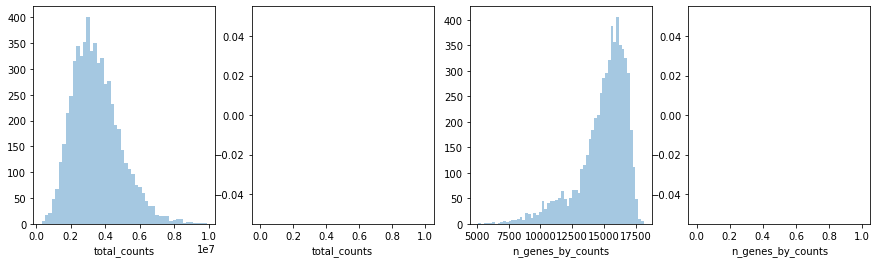

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

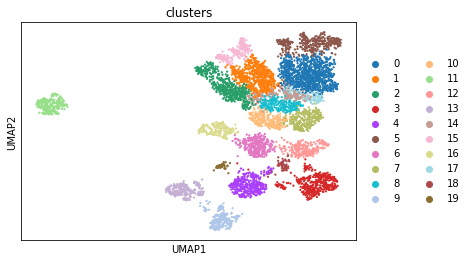

In [15]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")


sc.pl.umap(adata, color=["clusters"], wspace=0.4)



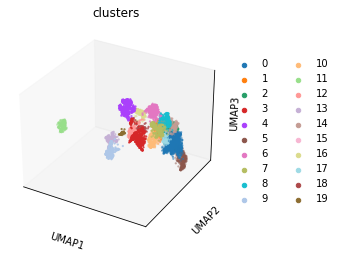

In [16]:
sc.tl.umap(adata,n_components=3)
sc.tl.leiden(adata, key_added="clusters")
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["clusters"], wspace=0.4,projection='3d')

In [18]:
#pip install py_pcha

In [17]:
from py_pcha import PCHA

#dimensions = 15
#examples = 100
#X = np.random.random((dimensions, examples))



In [18]:
#no_c = 50
#XC, S, C, SSE, varexpl = PCHA(adata.obsm['X_umap'].T, noc=no_c, delta=0.1)


In [19]:
tmp = pd.DataFrame(adata.X,index=adata.obs.index.values,columns=adata.var.index.values)
tmp.index.name = 'cell_id'
print(tmp.shape)
dt = tmp[tmp.columns.intersection(adata.var.loc[adata.var['highly_variable'] == True].index.values)]
print(dt.shape)

no_c = 6#20
XC, S, C, SSE, varexpl = PCHA(dt.T.to_numpy(), noc=no_c, delta=0.1)

(6000, 23381)
(6000, 6000)


eval_array = []
for ii in range(6,19):
    XC, S, C, SSE, varexpl = PCHA(dt.T.to_numpy(), noc=ii, delta=0.1)
    print(ii,varexpl.shape)
    eval_array.append(varexpl)
eval_array = np.array(eval_array)
eval_array

In [20]:
#B = adata.obsm['X_umap']#np.array([[1,4],[2,5],[3,6]])
#A = np.array(XC.T)#XC.T#np.array([[1,4],[3,6],[7,8]]) A, = np.array(M.T)

#dist = np.linalg.norm(np.expand_dims(A,axis=1)-np.expand_dims(B,axis=0),axis=2)
#dist.shape
B = dt.to_numpy()#ad1.obsm['X_umap']#np.array([[1,4],[2,5],[3,6]])
A = np.array(XC.T)#XC.T#np.array([[1,4],[3,6],[7,8]]) A, = np.array(M.T)

dist = np.linalg.norm(np.expand_dims(A,axis=1)-np.expand_dims(B,axis=0),axis=2)
dist.shape

dist_df = pd.DataFrame(dist, index=[f'cell_{i}' for i in range(1,no_c+1)],columns =adata.obs.index)
dist_df_t=dist_df.T
arches_val = []
arches_nn = []
arch_spots = []
arch_nn_spots = []
archs = []
#archs = []
for i in adata.obs.index:
    # first find min dist of arche for current spot
    ct = dist_df.index[dist_df[i].argsort()[0]]
    # check if in the closest 60 spots for that arche
    if i in dist_df_t.sort_values(by=[ct], ascending= 1).index[0:1]:#dist_df.loc[ct].argsort()[0:30].index:#wass_dist_df.loc[ct].argsort()[0:59].index:
        arches_val = np.append(arches_val,ct)
        arch_spots = np.append(arch_spots,i)
        archs = np.append(archs,int(ct.split('_')[1]))
    else:
        arches_val = np.append(arches_val,'nan')
        
    if i in dist_df_t.sort_values(by=[ct], ascending= 1).index[0:30]:#dist_df.loc[ct].argsort()[0:30].index:#wass_dist_df.loc[ct].argsort()[0:59].index:
        arches_nn = np.append(arches_nn,ct)
        arch_nn_spots = np.append(arch_nn_spots,i)
    else:
        arches_nn = np.append(arches_nn,'nan')





(6, 6000)

In [22]:
maxValueIndex = comp_df[arch_spots].idxmax(axis = 1)
maxValueIndex

KeyError: "None of [Index(['Spotx857', 'Spotx2703', 'Spotx3953', 'Spotx3971', 'Spotx4580',\n       'Spotx5603'],\n      dtype='object')] are in the [columns]"

In [ ]:
B_nn = dt.to_numpy()#adata.obsm['X_umap']#np.array([[1,4],[2,5],[3,6]])

A_nn = np.array(dt.loc[maxValueIndex])#adata[maxValueIndex].obsm['X_umap']#np.array(XC.T)#XC.T#np.array([[1,4],[3,6],[7,8]]) A, = np.array(M.T)

dist_nn = np.linalg.norm(np.expand_dims(A_nn,axis=1)-np.expand_dims(B_nn,axis=0),axis=2)
print(dist_nn.shape)

dist_df_nn = pd.DataFrame(dist_nn, index=maxValueIndex.values,columns =adata.obs.index)
dist_df_nn_t=dist_df_nn.T

dist_df_nn_t = dist_df_nn_t.loc[:,~dist_df_nn_t.columns.duplicated()]
dist_df_nn_t

In [26]:
adata.obs['arches_val'] = arches_val#adA.obs['arches_nn_val'] = arches_val
adata.obs['arches_nn'] = arches_nn

In [27]:
print(adata.obs.loc[maxValueIndex,'arches_val'].values)
adata.obs.loc[maxValueIndex,'arches_val']

['cell_5' 'cell_4' 'cell_1' 'cell_2' 'cell_6' 'cell_4']


Spotx695     cell_5
Spotx557     cell_4
Spotx2389    cell_1
Spotx1178    cell_2
Spotx1310    cell_6
Spotx557     cell_4
Name: arches_val, dtype: object

/Users/xueerchen/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/xueerchen/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'arches_val' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'arches_nn' as categorical
/Users/xueerchen/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lea

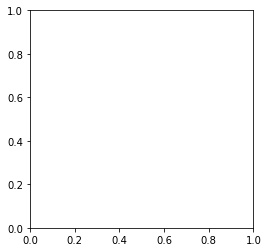

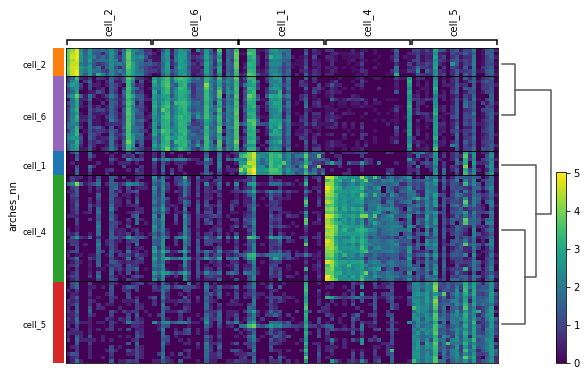

In [28]:
fig, ax = plt.subplots()
adata_arch = adata[adata.obs.loc[adata.obs['arches_nn'].isin(adata.obs.loc[maxValueIndex,'arches_val'].values)].index]
sc.tl.rank_genes_groups(adata_arch, "arches_nn", method="logreg",n_genes=20)
sc.tl.dendrogram(adata_arch, groupby='arches_nn')
sc.pl.rank_genes_groups_heatmap(adata_arch, n_genes=20, groupby="arches_nn")#, groups="5"

In [29]:
arch_deg_df = pd.DataFrame(adata_arch.uns['rank_genes_groups']['names']).head(20)
arch_deg_df

,cell_1,cell_2,cell_4,cell_5,cell_6
0,CD79A,S100A8,GNLY,CD3D,FCGR3A
1,CD79B,S100A9,NKG7,LDHB,RHOC
2,HLA-DRA,LYZ,GZMB,IL7R,IFITM2
3,CD74,LGALS2,FGFBP2,IL32,LST1
4,HLA-DQA1,CD14,PRF1,CD3E,MS4A7
5,MS4A1,GPX1,CST7,JUNB,IFITM3
6,HLA-DQB1,MS4A6A,CTSW,RGCC,AIF1
7,HLA-DPB1,CCL3,GZMA,AES,FCER1G
8,HLA-DRB1,IL8,CCL5,AQP3,TIMP1
9,HLA-DPA1,BLVRB,CCL4,NOSIP,LILRA3


In [30]:
exp_df_n = pd.DataFrame(adata.X)
exp_df_n.index = adata.obs.index
exp_df_n.columns = adata.var.index
exp_df_n.head()

,MIR1302-10,FAM138A,OR4F5,AL627309.1,AP006222.2,OR4F29,OR4F16,AL669831.1,FAM87B,LINC00115,...,KIR3DL2-1,AL590523.1,CT476828.1,PNRC2-1,SRSF10-1,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
Spotx5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
Spotx8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
Spotx13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
Spotx14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.91635,0.0,0.0,0.0,0.0,0.0,0.0
Spotx15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
adata.obs.loc[maxValueIndex,'arches_val'].values

array(['cell_5', 'cell_4', 'cell_1', 'cell_2', 'cell_6', 'cell_4'],
      dtype=object)

In [32]:
# fix prior var calculation
# var: average expression of signature genes, var across NN
vars_arch = []
tt = adata.obs
ttt = np.array(tt['arches_nn'].unique())
#x[~numpy.isnan(x)]
for i in adata.obs.loc[maxValueIndex,'arches_val'].values:#np.sort(adata.obs.loc[arch_spots,'arches_val'].values):#['cell_1', 'cell_2','cell_3','cell_4','cell_5','cell_6']:#ttt[~np.isnan(ttt)]:#cell_dic_plot.keys():
    
    mask = tt['arches_nn']==i
    spots = tt.loc[mask].index.values#adA.obs.loc[:,dA.obs.loc['arches_nn']].index.values()# df1.loc[:, df1.loc['a'] > 0]
    genes_sele = arch_deg_df[i]
    var_n = np.sqrt(exp_df_n.loc[spots][exp_df.columns.intersection(genes_sele)].sum(axis=1).var())
    vars_arch = np.append(vars_arch,var_n)
    
vars_arch

array([1.83852756, 3.96097279, 3.12724328, 1.40103638, 1.87688458,
       3.96097279])

In [33]:
comp_df[maxValueIndex]

,Spotx695,Spotx557,Spotx2389,Spotx1178,Spotx1310,Spotx557
CD4_Tcells,6,0,0,1,0,0
CD8_Tcells,0,0,0,0,0,0
Bcells,0,0,5,0,0,0
CD14_Monocytes,0,0,0,14,0,0
FCGR3A_Monocytes,0,0,0,0,7,0
NK_cells,0,8,0,0,0,8


In [34]:
unique_elements, counts_elements = np.unique(arches_val, return_counts=True)
print(unique_elements, counts_elements)

['cell_1' 'cell_2' 'cell_3' 'cell_4' 'cell_5' 'cell_6' 'nan'] [   1    1    1    1    1    1 1234]


markers_df = pd.read_csv('Tcellsignatures_june2020_sele.csv')#pd.read_csv('/Users/xueerchen/Documents/spatial/bc/Tcellsignatures_june2020.csv')##('mouse_brain_marker_gene-SH.csv')
cells = markers_df.columns.values
marker_genes = []
cell_dic = {}
cell_dic_plot = {}
for c in cells:
    cc = np.array(markers_df[c].values.tolist())
    marker_genes = np.append(marker_genes,[x for x in cc if str(x) != 'nan'])
    cell_dic[c] = [x for x in cc if str(x) != 'nan']
    cell_dic_plot[c] = [x for x in cc if str(x) != 'nan']
    

In [35]:
from statsmodels.stats.weightstats import ztest
cts = adata.obs.loc[maxValueIndex,'arches_val'].values#[f'cell_{i}' for i in range(1,len(arch_spots)+1)]
cell_dic = {}
for i in cts:#range(len(maxValueIndex)):
    #ct = cts[i]
    cell_dic[i] = arch_deg_df[i].values#adata_arch.uns['rank_genes_groups']['names'][i]


In [36]:
cell_dic

{'cell_5': array(['CD3D', 'LDHB', 'IL7R', 'IL32', 'CD3E', 'JUNB', 'RGCC', 'AES',
        'AQP3', 'NOSIP', 'TMEM66', 'LCK', 'LTB', 'TMEM123', 'EEF1B2',
        'CD2', 'DNAJB1', 'C6orf48', 'NPM1', 'CCR7'], dtype=object),
 'cell_4': array(['GNLY', 'NKG7', 'GZMB', 'FGFBP2', 'PRF1', 'CST7', 'CTSW', 'GZMA',
        'CCL5', 'CCL4', 'SPON2', 'CD247', 'GZMH', 'CLIC3', 'HOPX', 'CD7',
        'CCL3', 'AKR1C3', 'KLRD1', 'FCGR3A'], dtype=object),
 'cell_1': array(['CD79A', 'CD79B', 'HLA-DRA', 'CD74', 'HLA-DQA1', 'MS4A1',
        'HLA-DQB1', 'HLA-DPB1', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DMA',
        'HLA-DRB5', 'BANK1', 'TCL1A', 'HLA-DQA2', 'LTB', 'LINC00926',
        'HLA-DMB', 'TAF7', 'VPREB3'], dtype=object),
 'cell_2': array(['S100A8', 'S100A9', 'LYZ', 'LGALS2', 'CD14', 'GPX1', 'MS4A6A',
        'CCL3', 'IL8', 'BLVRB', 'GSTP1', 'CEBPD', 'SAT2', 'GRN', 'CST3',
        'FCN1', 'NFKBIA', 'AP1S2', 'ALDH2', 'VCAN'], dtype=object),
 'cell_6': array(['FCGR3A', 'RHOC', 'IFITM2', 'LST1', 'MS4A7', 'IFITM3', '

In [37]:
# degs 
from scipy import stats

adata.obs['groups'] = ['group 1' if int(i) < 9 else 'group 2' for i in adata.obs['louvain']]
sc.tl.rank_genes_groups(adata, groupby='groups', key_added='group_DE_results')

In [38]:
from __future__ import print_function, division

import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

#import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [39]:
class visiumDataset(Dataset):

    def __init__(self, exp_mat, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.spot_gene_exp = exp_mat
        idx = self.spot_gene_exp.index
        x = self.spot_gene_exp.values
        #x = np.log1p(x)
        self.spot_gene_exp = pd.DataFrame(x, columns=self.spot_gene_exp.columns, index=idx)
            
        #self.root_dir = root_dir
        #self.transform = transform

    def __len__(self):
        return len(self.spot_gene_exp)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = torch.Tensor(np.array(self.spot_gene_exp.iloc[idx,0:],dtype='float'))
        
        return sample





In [40]:
tmp = exp_df_n#pd.DataFrame(adata.X,index=adata.obs.index.values,columns=adata.var.index.values)
tmp.index.name = 'cell_id'
print(tmp.shape)
dt = tmp[tmp.columns.intersection(adata.var.loc[adata.var['highly_variable'] == True].index.values)]
dt.shape


genes = dt.columns.values


valid_cell_dic = {}
for c,m1 in cell_dic.items():
    m2 = [i for i in m1 if i in genes]
    #print(c,m2)
    if len(m2)>0:
        valid_cell_dic[c] = m2
        
len(valid_cell_dic)

cell_gene_ids = {}
gene2id = {i:c for c,i in enumerate(dt.columns.values.tolist())}
for k,v in valid_cell_dic.items():
    cell_gene_ids[k] = [gene2id[j] for j in v]
cells = [k for k in cell_gene_ids]

(1240, 24813)


cell_dic

In [41]:
class VAE(nn.Module):
    def __init__(self,H,M,vars_arch):
        super(VAE,self).__init__()

        #Latent View
        #self.lv = nn.Linear(50,20)
        
        self.vars_arch = torch.from_numpy(vars_arch).float()
        
        self.encoder = nn.Sequential(
            nn.Linear(M,40),#nn.Linear(M,400),
            nn.ReLU(),
            nn.Linear(40,H),#nn.Linear(400,H)
            #nn.ReLU(),
        )
        
         # distribution parameters
        # bottleneck size is 20
        #self.fc_mu = nn.Linear(50, 20)
        #self.fc_var = nn.Linear(50, 20)
        
        self.fc_mu_w = torch.nn.Parameter(torch.rand(H,H))
        self.fc_mu_b = torch.nn.Parameter(torch.rand(H))
        
        #self.fc_var_w = torch.nn.Parameter(torch.rand(H,H))
        #self.fc_var_b = torch.nn.Parameter(torch.rand(H))
        #self.ct_vars = torch.nn.Parameter(torch.tensor([0.89681379, 0.74543968, 1.        , 0.32596006, 0.38808593,0.74543968]))
        
        self.decoder = nn.Sequential(
            nn.Linear(H,H),#50
            nn.ReLU(),
            nn.Linear(H,40),#nn.Linear(H,400)
            nn.ReLU(),
            nn.Linear(40,M),#nn.Linear(400,6000)
        )
        
        # distribution parameters
        # bottleneck size is 20
        #self.fc_mu = nn.Linear(100, 20)
        #self.fc_var = nn.Linear(100, 20)

        # for the gaussian likelihood ????
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
        
    def forward(self, x, sample_cell_genes):
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        x_sample_cell = self.encoder(sample_cell_genes)#torch.eye(len(valid_cell_dic)).cuda()#self.encoder(sample_cell_genes)#*torch.eye(len(valid_cell_dic)).cuda()# multiply by identity mat or assign one identity mat directly
        
        mu = torch.matmul(x_encoded, self.fc_mu_w) + self.fc_mu_b#torch.matmul(x_encoded, self.fc_mu_w+x_sample_cell.T) + self.fc_mu_b
        #log_var = torch.matmul(x_encoded, self.fc_var_w) + self.fc_var_b#torch.matmul(x_encoded, self.fc_var_w+x_sample_cell.T) + self.fc_var_b
       
        mu_samp = torch.matmul(x_sample_cell, self.fc_mu_w) + self.fc_mu_b
        
        tt = torch.tensor(self.vars_arch)#self.vars_arch
        #print(len(tt))
        std_samp = tt.repeat(mu_samp.shape[0], 1)#0.01*torch.ones(mu_samp.shape[0],mu_samp.shape[1]).cuda()#tt.repeat(mu_samp.shape[0], 1)#torch.exp(log_var_samp / 2)#0.1*torch.ones(mu_samp.shape[0],mu_samp.shape[1])#torch.exp(log_var_samp / 2)
        # sample z from q
        std = tt.repeat(mu.shape[0], 1)
        
        #std_samp = self.ct_vars.repeat(mu_samp.shape[0], 1)#torch.exp(log_var_samp / 2)#0.01*torch.ones(mu_samp.shape[0],mu_samp.shape[1])#tt.repeat(mu_samp.shape[0], 1)#torch.exp(log_var_samp / 2)#0.01*torch.ones(mu_samp.shape[0],mu_samp.shape[1])#tt.repeat(mu_samp.shape[0], 1)#torch.from_numpy(np.repeat(vars_arch,mu_samp.shape[0],axis=0).reshape((mu_samp.shape[1], mu_samp.shape[0])).T)#0.01*torch.ones(mu_samp.shape[0],mu_samp.shape[1])#torch.exp(log_var_samp / 2)
        # sample z from q
        #std = self.ct_vars.repeat(mu.shape[0], 1)#torch.exp(log_var / 2)#0.01*torch.ones(mu.shape[0],mu.shape[1])#tt.repeat(mu.shape[0], 1)#torch.exp(log_var / 2)#0.01*torch.ones(mu.shape[0],mu.shape[1])#tt.repeat(mu.shape[0], 1)#torch.from_numpy(np.repeat(vars_arch,mu.shape[0],axis=0).reshape((mu.shape[1], mu.shape[0])).T)#0.01*torch.ones(mu.shape[0],mu.shape[1])#torch.exp(log_var / 2)
        #eps = torch.randn_like(std)
        #z = mu + (eps*std)
        q = torch.distributions.Normal(mu, std)#torch.distributions.Normal(mu, 0.1*torch.ones(mu.shape[0],mu.shape[1]))#(mu, std)
        z = q.rsample()
        
        q_samp = torch.distributions.Normal(mu_samp, std_samp)#(mu_samp, 0.1*torch.ones(mu_samp.shape[0],mu_samp.shape[1]))#(mu_samp, std_samp)
        z_samp = q_samp.rsample()
        
        #z_samp = torch.eye(len(valid_cell_dic)).cuda()#np.identity(len(valid_cell_dic))

        # decoded 
        x_samp_hat = vae.decoder(z_samp)
        x_hat = vae.decoder(z) #?? self.
        return x_encoded,x_sample_cell,x_hat,x_samp_hat,z,z_samp,mu,std,mu_samp,std_samp
        

In [42]:
def gaussian_likelihood(mean, logscale, sample):
    scale = torch.exp(logscale)
    dist = torch.distributions.Normal(mean, scale)
    log_pxz = dist.log_prob(sample)
    return log_pxz.sum(dim=1)

def kl_divergence(z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    kl = kl.sum(-1)
    return kl

In [44]:
y = pd.get_dummies(adata.obs.loc[arch_spots,'arches_val'])
#y=y.drop(columns=['nan'])
print(y.head())

           cell_1  cell_2  cell_3  cell_4  cell_5  cell_6
cell_id                                                  
Spotx557        0       0       0       1       0       0
Spotx695        0       0       0       0       1       0
Spotx1178       0       1       0       0       0       0
Spotx1310       0       0       0       0       0       1
Spotx2311       0       0       1       0       0       0


In [45]:
y_nn = pd.get_dummies(adata.obs.loc[arch_nn_spots,'arches_nn'])
#y_nn=y_nn.drop(columns=['nan'])
print(y_nn.head())

         cell_1  cell_2  cell_3  cell_4  cell_5  cell_6
cell_id                                                
Spotx5        0       0       0       1       0       0
Spotx15       0       0       0       0       0       1
Spotx39       0       0       0       1       0       0
Spotx53       0       0       1       0       0       0
Spotx79       0       1       0       0       0       0


In [46]:

dt = exp_df_sele[exp_df_sele.columns.intersection(adata.var.loc[adata.var['highly_variable'] == True].index.values)]#tmp[tmp.columns.intersection(adA.var.loc[adA.var['highly_variable'] == True].index.values)]
vd = visiumDataset(exp_mat=dt)


import matplotlib.pyplot as plt
#plt.hist(dt.sum(axis=1))
#plt.show()

batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=vd,#dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 num_workers=8,
                 #prefetch_factor=64,
)

x = next(iter(train_loader))
x.shape

x.min(), x.max(), x.mean()

x.shape

torch.Size([128, 6000])

z_sample_cell_label = adA.obs.loc[arch_spots,'arches_val'].values
print(type(z_sample_cell_label))
np.array(z_sample_cell_label)

archs

In [47]:
comp_df[maxValueIndex]

,Spotx695,Spotx557,Spotx2389,Spotx1178,Spotx1310,Spotx557
CD4_Tcells,6,0,0,1,0,0
CD8_Tcells,0,0,0,0,0,0
Bcells,0,0,5,0,0,0
CD14_Monocytes,0,0,0,14,0,0
FCGR3A_Monocytes,0,0,0,0,7,0
NK_cells,0,8,0,0,0,8


In [48]:
archs_sele = comp_df[maxValueIndex].index
archs_sele

Index(['CD4_Tcells', 'CD8_Tcells', 'Bcells', 'CD14_Monocytes',
       'FCGR3A_Monocytes', 'NK_cells'],
      dtype='object')

maxValueIndex archs_sele

recon_loss_samp = gaussian_likelihood(x_samp_hat, vae_gpu.log_scale, sample_signatures)
recon_loss_samp.cpu().detach()

In [49]:
%%time

# add loss for sample spots
# move data to gpu
z_sample_cell_label = torch.from_numpy(y_nn[y.columns].to_numpy())#torch.range(0,len(archs_sele)-1).long()#torch.Tensor(archs_sele).long()
H=len(vars_arch)+0#int(z_sample_cell_label.max())+1#no_c#len(valid_cell_dic)
M = dt.shape[1]
vae = VAE(H,M,vars_arch)
print(vae)
vae_gpu = vae#.cuda()
optimizer = torch.optim.Adam(vae_gpu.parameters(),lr=1e-3)
#a.repeat(3)
 
xx = dt.loc[arch_nn_spots]#dt.loc[maxValueIndex]#pd.DataFrame.sparse.from_spmatrix(arch_spots_exp.X)
#xx.columns = adata.var.index.values

sample_signatures = xx[dt.columns].to_numpy()#fix_cell_genes(len(cell_gene_ids.keys()),M)#fix_cell_genes(N=len(cell_gene_ids.keys()))#sample_cell_genes(20)
sample_signatures_r = sample_signatures#np.repeat(sample_signatures, repeats=1, axis=0)
sample_signatures_r = torch.from_numpy(sample_signatures_r).float()#.cuda()


EPOCHS = 200
for epoch in range(EPOCHS):
    losses = []
    elbos = []
    corr_ls = []
    ces = []
    for batch_idx,data in enumerate(train_loader):
        #data = torch.autograd.Variable(data)
        #data = data#.cuda()
        #sample_signatures = fix_cell_genes(len(cell_gene_ids.keys()),M)#fix_cell_genes(N=len(cell_gene_ids.keys()))#sample_cell_genes(20)
        #sample_signatures_r = np.repeat(sample_signatures, repeats=5, axis=0)
        #sample_signatures_r = torch.from_numpy(sample_signatures_r).float().cuda()

        optimizer.zero_grad()
        #x_encoded,x_sample_cell,x_hat,z,mu,std
        #x_encoded,x_sample_cell,x_hat,x_samp_hat,z,z_samp,mu,std
        x_encoded,x_sample_cell,x_hat,x_samp_hat,z,z_samp,mu,std,mu_samp,std_samp = vae_gpu(data,sample_signatures_r)
        
        # reconstruction loss
        #recon_loss = F.mse_loss(x_hat,data)
        #recon_loss = (x_hat - data).pow(2).mean(dim=1)
        recon_loss = gaussian_likelihood(x_hat, vae_gpu.log_scale, data)
        recon_loss_samp = gaussian_likelihood(x_samp_hat, vae_gpu.log_scale, sample_signatures_r)
        
        kl = kl_divergence(z, mu, std)
        #kl = torch.mean(-0.5 * torch.sum(1 + std - mu ** 2 - std.exp(), dim = 1), dim = 0)
        # elbo
        beta = 1
        elbo = (beta*kl - recon_loss)#(kl - recon_loss)#try beta vae
        elbo = elbo.mean()
        
        #ce = F.cross_entropy(mu_samp, z_sample_cell_label)
        ce_func = nn.BCEWithLogitsLoss()#F.cross_entropy(mu_samp, z_sample_cell_label)
        ce = ce_func(mu_samp[:,0:len(vars_arch)],z_sample_cell_label.float())#ce_func(mu_samp,z_sample_cell_label.float())

        
        loss = elbo + ce#*50
        
        ces.append(ce.item())#ces.append(ce.cpu().detach().item())
        
        elbos.append(elbo.item())#elbos.append(elbo.cpu().detach().item())
        #corr_ls.append(loss_corr.cpu().detach().item())
        #losses.append(loss.cpu().detach().item())
        
        loss.backward()
        optimizer.step()

    #l = f'Loss:{np.mean(losses):.2f}'
    el = f'Elbo Loss:{np.mean(elbos):.2f}'
    cel = f'Cross Entropy Loss:{np.mean(ces):.2f}'
    #cl = f'Corr Loss:{np.mean(corr_ls):.2f}'
    #print(f'\r Train Epoch: {epoch+1}/{EPOCHS} {l} {el} {cl}')
    print(f'\r Train Epoch: {epoch+1}/{EPOCHS} {el} {cel}')


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=6000, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=6000, bias=True)
  )
)
 Train Epoch: 1/200 Elbo Loss:168395.69 Cross Entropy Loss:2.32
 Train Epoch: 2/200 Elbo Loss:166164.54 Cross Entropy Loss:1.83
 Train Epoch: 3/200 Elbo Loss:161824.90 Cross Entropy Loss:4.08
 Train Epoch: 4/200 Elbo Loss:156375.04 Cross Entropy Loss:8.47
 Train Epoch: 5/200 Elbo Loss:146834.22 Cross Entropy Loss:14.36
 Train Epoch: 6/200 Elbo Loss:133913.40 Cross Entropy Loss:21.31
 Train Epoch: 7/200 Elbo Loss:117508.54 Cross Entropy Loss:28.17
 Train Epoch: 8/200 Elbo Loss:99612.43 Cross Entropy Loss:32.14
 Train Epoch: 9/200 Elbo Loss:83033.02 Cross Entropy Loss:36.47
 Train E

In [50]:
alldata_loader = torch.utils.data.DataLoader(
                 dataset=vd,#dataset=train_set,
                 batch_size=len(vd),
                 #shuffle=True,
                 num_workers=8,
                 #prefetch_factor=64,
)





In [51]:
for batch_idx,alldata in enumerate(alldata_loader):
    print(batch_idx,alldata.size()) 
    #sample_signatures = fix_cell_genes(len(cell_gene_ids.keys()),M)#sample_cell_genes(20)
    #sample_signatures_r = np.repeat(sample_signatures, repeats=5, axis=0)
    #sample_signatures_r = torch.from_numpy(sample_signatures_r).float().cuda()
    #sample_signatures = torch.from_numpy(sample_signatures).float().cuda()
    #x_encoded,x_sample_cell,x_hat,z,mu,std
    
    x_encoded,x_sample_cell,x_hat_all,x_samp_hat,z_all,z_samp,mu_all,std_all,mu_samp,std_samp = vae_gpu(alldata,sample_signatures_r)#vae_gpu(alldata.cuda(),sample_signatures_r) 

0 torch.Size([1240, 6000])


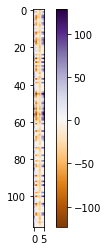

In [52]:
m = x_sample_cell.detach().numpy()
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (9,9)
im = ax.imshow(m,
               cmap="PuOr")
cbar = ax.figure.colorbar(im, ax=ax)



In [53]:
#0.00716778, 0.01349257, 0.02219315, 0.00976343, 0.00972585,0.0148446

(array([   0.,    0.,    0.,    0.,    0., 1240.,    0.,    0.,    0.,
           0.]),
 array([3.4609728, 3.5609727, 3.6609728, 3.7609727, 3.860973 , 3.9609728,
        4.0609727, 4.1609726, 4.260973 , 4.360973 , 4.460973 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

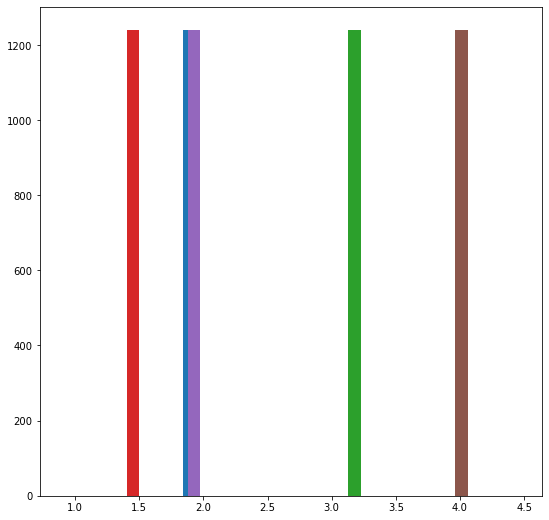

In [54]:
plt.hist(std_all.detach().numpy()[:,0])
plt.hist(std_all.detach().numpy()[:,1])
plt.hist(std_all.detach().numpy()[:,2])
plt.hist(std_all.detach().numpy()[:,3])
plt.hist(std_all.detach().numpy()[:,4])
plt.hist(std_all.detach().numpy()[:,5])

In [55]:
#comp_df = pd.DataFrame({'pred':np.argmax(mu_all.cpu().detach().numpy(),axis=1),'true':cell_ids})
#pd.crosstab(index=comp_df['pred'], columns=comp_df['true'])

In [56]:
bn_all_np = mu_all.cpu().detach().numpy()
#bn_all_np = mu_all.cpu().detach().numpy()
#bn_all_np = z_all.cpu().detach().numpy()
bn_df = pd.DataFrame(bn_all_np)
bn_df.columns = ['bn'+str(i+1) for i in bn_df.columns]

In [57]:
bn_df.head()

,bn1,bn2,bn3,bn4,bn5,bn6
0,-24.714102,-36.830231,-32.114269,15.351685,12.895791,-1.841752
1,-23.419636,20.307394,16.670261,-9.709234,26.169550,-12.178373
2,-20.992933,6.590677,5.203954,-8.637793,17.626350,-10.076405
3,3.863987,0.077063,9.707438,23.232307,4.700150,10.109114
4,-33.520439,18.102295,28.117014,16.380266,24.752270,-14.973825


In [58]:
tmp = pd.DataFrame(adata.X,index=adata.obs.index.values,columns=adata.var.index.values)
tmp.index.name = 'cell_id'
#print(tmp.shape)
dt = tmp[tmp.columns.intersection(adata.var.loc[adata.var['highly_variable'] == True].index.values)]
dt.shape

bn_df.index = dt.index

# Declaring rows
N = len(bn_df.columns.values[bn_df.max(axis=0) > 0])#bn_df.shape[1]
  
# Declaring columns
M = len(valid_cell_dic)
  
# Using * operator twice to initialize matrix
cor_bn_ct = np.array([[0] * M] * N)
print(cor_bn_ct.shape)
#res[0,0]
cor_bn_ct_df = pd.DataFrame(cor_bn_ct, columns = valid_cell_dic.keys(), index = bn_df.columns.values[bn_df.max(axis=0) > 0])
cor_bn_ct_df.iloc[0,0]

(6, 5)


0

In [59]:
# v1
for k in valid_cell_dic.keys():
    gs = valid_cell_dic[k]
    ttt = pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)/dt.shape[0]], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], exp_mat[exp_mat.columns.intersection(gs)].sum(axis=1)], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)/dt.shape[0]], axis=1)
    
    tt = ttt.corr()
    
    for j in bn_df.columns.values[bn_df.max(axis=0) > 0]:
        data = np.array([tt[j].index,tt[j].tolist()])
        df = pd.DataFrame(data.T, columns = ['Name', 'cor_score']) 
        df.index = df['Name']
        #df = df[~df.Name.str.contains("bn")]#df.drop(index=bn_df.columns.values[bn_df.max(axis=0) > 0].tolist())
        #df_s = df.sort_values(by=['cor_score'], ascending=False)
        #mask = df_s['cor_score']>0.5
        #feas = df_s.loc[mask,'Name'].values
        cor_bn_ct_df.loc[j,k] = df['cor_score'][0]
        



In [60]:
# or calculate cors for each signature gene and then average
#v2
for k in valid_cell_dic.keys():
    gs = valid_cell_dic[k]
    ttt = pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)]], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)/dt.shape[0]], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], exp_mat[exp_mat.columns.intersection(gs)].sum(axis=1)], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)/dt.shape[0]], axis=1)
    
    
    tt = ttt.corr()
    
    for j in bn_df.columns.values[bn_df.max(axis=0) > 0]:
        data = np.array([tt[j].index,tt[j].tolist()])
        df = pd.DataFrame(data.T, columns = ['Name', 'cor_score']) 
        df.index = df['Name']
        #df = df[~df.Name.str.contains("bn")]#df.drop(index=bn_df.columns.values[bn_df.max(axis=0) > 0].tolist())
        #df_s = df.sort_values(by=['cor_score'], ascending=False)
        #mask = df_s['cor_score']>0.5
        #feas = df_s.loc[mask,'Name'].values
        cor_bn_ct_df.loc[j,k] = df['cor_score'][gs].sum()/len(gs)
        



In [61]:
#v3
for k in valid_cell_dic.keys():
    gs = valid_cell_dic[k]
    ttt = pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)]], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)/dt.shape[0]], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], exp_mat[exp_mat.columns.intersection(gs)].sum(axis=1)], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)], axis=1)#pd.concat([bn_df[bn_df.columns[bn_df.max(axis=0) > 0]], dt[dt.columns.intersection(gs)].sum(axis=1)/dt.shape[0]], axis=1)
    
    
    tt = ttt.corr()
    
    for j in bn_df.columns.values[bn_df.max(axis=0) > 0]:
        data = np.array([tt[j].index,tt[j].tolist()])
        df = pd.DataFrame(data.T, columns = ['Name', 'cor_score']) 
        df.index = df['Name']
        #df = df[~df.Name.str.contains("bn")]#df.drop(index=bn_df.columns.values[bn_df.max(axis=0) > 0].tolist())
        #df_s = df.sort_values(by=['cor_score'], ascending=False)
        #mask = df_s['cor_score']>0.5
        #feas = df_s.loc[mask,'Name'].values
        cor_bn_ct_df.loc[j,k] = df['cor_score'][gs].max()#/len(gs)
        




In [62]:
cor_bn_ct_df

,cell_5,cell_4,cell_1,cell_2,cell_6
bn1,0.313699,0.235655,0.403469,-0.307438,-0.189642
bn2,-0.014999,0.176606,0.622428,0.726189,0.706332
bn3,0.143069,-0.008893,0.618872,0.608368,0.627145
bn4,0.522910,0.232085,0.522910,-0.348261,0.092439
bn5,-0.051180,0.469429,0.452882,0.718722,0.653513
bn6,0.417792,0.373488,0.457397,-0.264227,-0.138684


Text(0, 0.5, 'correlation')

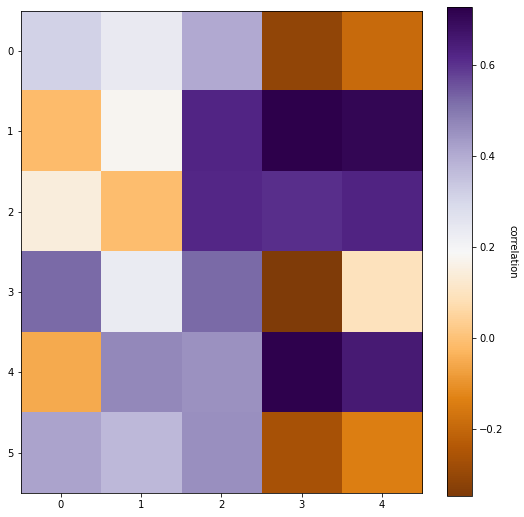

In [63]:
fig, ax = plt.subplots()

im = ax.imshow(cor_bn_ct_df,
               cmap="PuOr")

cbar = ax.figure.colorbar(im, ax=ax)#, **cbar_kw
cbar.ax.set_ylabel('correlation', rotation=-90, va="bottom")



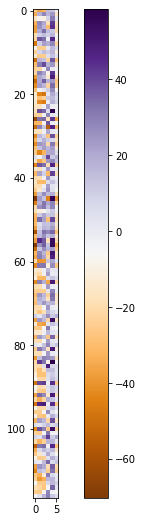

In [64]:
from scipy.special import softmax
m = mu_samp.detach().numpy()
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (9,9)
im = ax.imshow(m,
               cmap="PuOr")
cbar = ax.figure.colorbar(im, ax=ax)




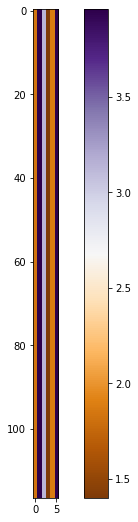

In [65]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (9,9)
im = ax.imshow(std_samp.detach().numpy(),
               cmap="PuOr")
cbar = ax.figure.colorbar(im, ax=ax)



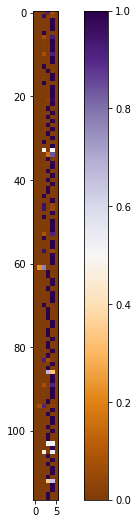

In [66]:
from scipy.special import softmax
m = softmax(mu_samp.detach().numpy(), axis=1)
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (9,9)
im = ax.imshow(m,
               cmap="PuOr")
cbar = ax.figure.colorbar(im, ax=ax)



In [73]:

mu_all_s = softmax(z_all.detach().numpy(), axis=1)#softmax(z_all.detach().numpy(), axis=1)#mu_all
#m
mu_all_s.sum(axis=1)

array([1.0000004 , 1.0000007 , 0.9999996 , ..., 1.0000006 , 1.0000004 ,
       0.99999976], dtype=float32)

In [74]:
comp_df_sele_s = softmax(comp_df_sele, axis=0)#mu_all
#m
comp_df_sele_s.sum(axis=0)

Spotx5       1.0
Spotx8       1.0
Spotx13      1.0
Spotx14      1.0
Spotx15      1.0
            ... 
Spotx2994    1.0
Spotx2995    1.0
Spotx2996    1.0
Spotx2997    1.0
Spotx3000    1.0
Length: 1240, dtype: float64

In [69]:
from scipy.spatial import distance

In [76]:
comp_df_sele.index

Index(['CD4_Tcells', 'CD8_Tcells', 'Bcells', 'CD14_Monocytes',
       'FCGR3A_Monocytes', 'NK_cells'],
      dtype='object')

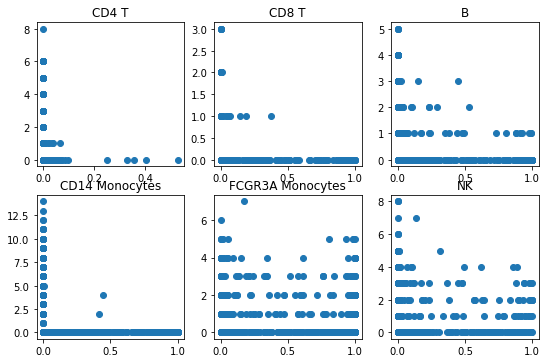

In [77]:
fig = plt.figure()

plt.subplot(3, 3, 1)
plt.scatter(mu_all_s[:,0], comp_df_sele.loc['CD4_Tcells'])
plt.title("CD4 T")

plt.subplot(3, 3, 2)
plt.scatter(mu_all_s[:,1], comp_df_sele.loc['CD8_Tcells'])
plt.title("CD8 T")

plt.subplot(3, 3, 3)
plt.scatter(mu_all_s[:,2], comp_df_sele.loc['Bcells'])
plt.title("B")

plt.subplot(3, 3, 4)
plt.scatter(mu_all_s[:,3], comp_df_sele.loc['CD14_Monocytes'])
plt.title("CD14 Monocytes")

plt.subplot(3, 3, 5)
plt.scatter(mu_all_s[:,4], comp_df_sele.loc['FCGR3A_Monocytes'])
plt.title("FCGR3A Monocytes")

plt.subplot(3, 3, 6)
plt.scatter(mu_all_s[:,5], comp_df_sele.loc['NK_cells'])
plt.title("NK")

plt.show()

In [ ]:
plt.subplot()
plt.scatter(mu_all_s[:,2], dt['CD19'])#'FCGR3A'

#x_encoded,x_sample_cell,x_hat_all,x_samp_hat,z_all,z_samp,mu_all,std_all,mu_samp
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (9,9)
im = ax.imshow(z_samp.cpu().detach().numpy(),
               cmap="PuOr")



In [ ]:
plt.subplot()
plt.scatter(mu_all_s[:,4], dt['FCGR3A'])#'FCGR3A'

In [ ]:
g=sns.clustermap(x_encoded.cpu().detach().numpy(),cmap='coolwarm')
ax = g.ax_heatmap
ax.set_ylabel("")

In [ ]:
for i in bn_df.columns:
    adata.obs[i] = bn_df[i].values
    sc.pl.umap(adata, color=i)

In [ ]:
print(math.sqrt(np.square(np.subtract(comp_df_sele_s.loc['CD4 T'], mu_all_s[:,0])).mean()))
print(math.sqrt(np.square(np.subtract(mu_all_s[:,1], comp_df_sele_s.loc['CD8 T'])).mean()))
print(math.sqrt(np.square(np.subtract(mu_all_s[:,2], comp_df_sele_s.loc['B'])).mean()))
print(math.sqrt(np.square(np.subtract(mu_all_s[:,3], comp_df_sele_s.loc['CD14 Monocytes'])).mean()))
print(math.sqrt(np.square(np.subtract(mu_all_s[:,4], comp_df_sele_s.loc['FCGR3A Monocytes'])).mean()))
print(math.sqrt(np.square(np.subtract(mu_all_s[:,5], comp_df_sele_s.loc['NK'])).mean()))